In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

dataPath = "/content/drive/MyDrive/MDataFiles_Stage2"
csvFiles = dict()
for filename in os.listdir(dataPath):
  name = filename[0:len(filename)-4]
  filePathTmp = dataPath + "/" + filename
  if (name == "MTeamSpellings"):
    csvFiles[name] = pd.read_csv(filePathTmp, encoding = "mac_roman")
  else:
    csvFiles[name] = pd.read_csv(filePathTmp)

Mounted at /content/drive


In [ ]:
tourney_results = csvFiles["MNCAATourneyDetailedResults"].copy()
regular_results = csvFiles['MRegularSeasonDetailedResults'].copy()
seeds = csvFiles['MNCAATourneySeeds'].copy()
df_test = csvFiles["MSampleSubmissionStage2"].copy()
df_test['Season'] = df_test['ID'].apply(lambda x: int(x.split('_')[0]))
df_test['TeamIDA'] = df_test['ID'].apply(lambda x: int(x.split('_')[1]))
df_test['TeamIDB'] = df_test['ID'].apply(lambda x: int(x.split('_')[2]))
NCAA2022Teams = np.unique(np.concatenate([np.unique(df_test['TeamIDA']),np.unique(df_test['TeamIDB'])]))

In [ ]:
def preprocess_csv(df):
    df['WEFFG'] = df['WFGM'] / df['WFGA']
    df["WEFFG3"] = df['WFGM3'] / df['WFGA3']
    # 2pt goal
    df['WFGM2'] = df['WFGM'] - df['WFGM3']
    df['WFGA2'] = df['WFGA'] - df['WFGA3']
    df["WEFFG2"] = df['WFGM2'] / df['WFGA2']

    df['LEFFG'] = df['LFGM'] / df['LFGA']
    df["LEFFG3"] = df['LFGM3'] / df['LFGA3']

    # 2pt goal
    df['LFGM2'] = df['LFGM'] - df['LFGM3']
    df['LFGA2'] = df['LFGA'] - df['LFGA3']
    df["LEFFG2"] = df['LFGM2'] / df['LFGA2']

    df = df.rename(columns={"WLoc":"location"})
    
    # # Check if removing the matches not containing teams in the tournament would result in teams
    # # not being in the df:
    # amountOfTeamsNotInFilteringDFW = len(list(set(NCAA2022Teams) - set(df["WTeamID"])))
    # amountOfTeamsNotInFilteringDFL = len(list(set(NCAA2022Teams) - set(df["LTeamID"])))
    # if (amountOfTeamsNotInFilteringDFL == 0 and amountOfTeamsNotInFilteringDFW == 0):
    df = df.loc[(df['WTeamID'].isin(NCAA2022Teams)) & (df['LTeamID'].isin(NCAA2022Teams))]

    return df

regular_results = preprocess_csv(csvFiles['MRegularSeasonDetailedResults'].copy())
regular_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,location,NumOT,WFGM,WFGA,...,WEFFG,WEFFG3,WFGM2,WFGA2,WEFFG2,LEFFG,LEFFG3,LFGM2,LFGA2,LEFFG2
2,2003,11,1266,73,1437,61,N,0,24,58,...,0.413793,0.444444,16,40,0.400000,0.301370,0.115385,19,47,0.404255
30,2003,16,1314,71,1353,67,H,0,27,57,...,0.473684,0.357143,22,43,0.511628,0.409091,0.409091,18,44,0.409091
95,2003,18,1394,83,1168,76,N,0,29,51,...,0.568627,0.250000,27,43,0.627907,0.414286,0.210526,25,51,0.490196
146,2003,19,1371,77,1362,51,H,0,32,65,...,0.492308,0.421053,24,46,0.521739,0.346154,0.277778,13,34,0.382353
164,2003,19,1460,78,1103,75,H,0,30,56,...,0.535714,0.500000,24,44,0.545455,0.571429,0.363636,24,38,0.631579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102024,2022,131,1437,54,1166,48,N,0,19,57,...,0.333333,0.250000,11,25,0.440000,0.327586,0.103448,16,29,0.551724
102025,2022,131,1439,82,1181,67,N,0,32,64,...,0.500000,0.454545,22,42,0.523810,0.489796,0.200000,20,29,0.689655
102027,2022,132,1222,71,1272,53,N,0,25,58,...,0.431034,0.333333,17,34,0.500000,0.431373,0.100000,21,41,0.512195
102028,2022,132,1234,75,1345,66,N,0,26,61,...,0.426230,0.285714,18,33,0.545455,0.423729,0.250000,20,39,0.512821


In [ ]:
def prepare_data(df):
    swapcols = [x.replace('W','$').replace('L','W') for x in list(df.columns)]
    swapcols = [x.replace('$','L') for x in swapcols]
    dfswap = df[swapcols]

    dfswap.loc[df['location'] == 'H', 'location'] = 'A'
    dfswap.loc[df['location'] == 'A', 'location'] = 'H'
      
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]

    output = pd.concat([df, dfswap])
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)

    output['PointDiff'] = output['T1_Score'] - output['T2_Score']

    return output
regular_data = prepare_data(regular_results.copy())
regular_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,...,T1_EFFG3,T1_FGM2,T1_FGA2,T1_EFFG2,T2_EFFG,T2_EFFG3,T2_FGM2,T2_FGA2,T2_EFFG2,PointDiff
2,2003,11,1266,73,1437,61,0,0,24,58,...,0.444444,16,40,0.400000,0.301370,0.115385,19,47,0.404255,12
30,2003,16,1314,71,1353,67,1,0,27,57,...,0.357143,22,43,0.511628,0.409091,0.409091,18,44,0.409091,4
95,2003,18,1394,83,1168,76,0,0,29,51,...,0.250000,27,43,0.627907,0.414286,0.210526,25,51,0.490196,7
146,2003,19,1371,77,1362,51,1,0,32,65,...,0.421053,24,46,0.521739,0.346154,0.277778,13,34,0.382353,26
164,2003,19,1460,78,1103,75,1,0,30,56,...,0.500000,24,44,0.545455,0.571429,0.363636,24,38,0.631579,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102024,2022,131,1166,48,1437,54,0,0,19,58,...,0.103448,16,29,0.551724,0.333333,0.250000,11,25,0.440000,-6
102025,2022,131,1181,67,1439,82,0,0,24,49,...,0.200000,20,29,0.689655,0.500000,0.454545,22,42,0.523810,-15
102027,2022,132,1272,53,1222,71,0,0,22,51,...,0.100000,21,41,0.512195,0.431034,0.333333,17,34,0.500000,-18
102028,2022,132,1345,66,1234,75,0,0,25,59,...,0.250000,20,39,0.512821,0.426230,0.285714,18,33,0.545455,-9


In [ ]:
tourney_results = preprocess_csv(tourney_results)
tourney_data = prepare_data(tourney_results.copy())


In [ ]:
tourney_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,...,T1_EFFG3,T1_FGM2,T1_FGA2,T1_EFFG2,T2_EFFG,T2_EFFG3,T2_FGM2,T2_FGA2,T2_EFFG2,PointDiff
1,2003,136,1112,80,1436,51,0,0,31,66,...,0.304348,24,43,0.558140,0.312500,0.250000,16,48,0.333333,29
6,2003,136,1181,67,1161,57,0,0,19,54,...,0.307692,15,41,0.365854,0.333333,0.272727,15,43,0.348837,10
20,2003,137,1231,67,1104,62,0,0,19,49,...,0.388889,12,31,0.387097,0.423077,0.416667,17,40,0.425000,5
27,2003,137,1345,80,1261,56,0,0,27,52,...,0.562500,18,36,0.500000,0.333333,0.230769,14,34,0.411765,24
33,2003,138,1112,96,1211,95,0,2,34,74,...,0.291667,27,50,0.540000,0.441558,0.366667,23,47,0.489362,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,2021,148,1425,66,1211,85,0,0,24,62,...,0.266667,20,47,0.425532,0.500000,0.333333,26,45,0.577778,-19
1177,2021,148,1276,49,1417,51,0,0,20,51,...,0.272727,17,40,0.425000,0.388889,0.230769,18,41,0.439024,-2
1178,2021,152,1222,59,1124,78,0,0,21,55,...,0.315789,15,36,0.416667,0.527273,0.458333,18,31,0.580645,-19
1179,2021,152,1417,90,1211,93,0,1,34,59,...,0.470588,26,42,0.619048,0.587302,0.333333,30,42,0.714286,-3


In [ ]:
len(list(set(NCAA2022Teams) - set(regular_data["T2_TeamID"])))

0

# Markov Model Making

In [ ]:
def create_transition_probability_matrix(state_list):
    dim = len(state_list)
    transiction_mtx_df = pd.DataFrame(
        data=np.zeros((dim, dim)),
        index=state_list,  #['s_1', 'a_F_a_1', 'a_F_a_1'],
        columns=state_list
    )
    return transiction_mtx_df


In [ ]:
def create_state_lists():
    index_list = ["ball_1", "ball_2"]
    index_list.append(f"sh_1")
    index_list.append(f"sh_2")
    index_list.append(f"pf_1")
    index_list.append(f"pf_2")
    for state in ["sh", "pf"]:

      if (state == "pf"):
        pts = ["0", "1", "2"]
      else:
        pts = ["2", "3"]
      for pt in pts:
          index_list.append(f"{state}_{pt}_1")
          index_list.append(f"{state}_{pt}_2")
    return index_list
state_list = create_state_lists()

In [ ]:
transition_probs = create_transition_probability_matrix(state_list)
transition_probs

,ball_1,ball_2,sh_1,sh_2,pf_1,pf_2,sh_2_1,sh_2_2,sh_3_1,sh_3_2,pf_0_1,pf_0_2,pf_1_1,pf_1_2,pf_2_1,pf_2_2
ball_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ball_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sh_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sh_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pf_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pf_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sh_2_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sh_2_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sh_3_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sh_3_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def get_trans_probability(trans_df, row, ft_val=2,pseudocounts=0.01):

  for team_num in range(1, 3):
    opp_num = 3 - team_num
    ft_num = int(row[f"T{team_num}_FTA"] / ft_val)
    turn_over_num = int(row[f"T{team_num}_TO"])
    fga_num = int(row[f"T{team_num}_FGA"])
    total_sh = fga_num + ft_num + turn_over_num



    trans_df.at[f"ball_{team_num}", f"pf_{team_num}"] = (ft_num+pseudocounts) / (total_sh+(3*pseudocounts))
    trans_df.at[f"ball_{team_num}", f"sh_{team_num}"] = (fga_num+pseudocounts) / (total_sh+(3*pseudocounts))
    trans_df.at[f"ball_{team_num}", f"ball_{opp_num}"] = (turn_over_num+pseudocounts) / (total_sh+(3*pseudocounts))
    rebound_num = (int(row[f"T{team_num}_OR"])+int(row[f"T{opp_num}_DR"])+2*pseudocounts)
    or_rate = (int(row[f"T{team_num}_OR"])+pseudocounts) / rebound_num
    dr_rate = (int(row[f"T{opp_num}_DR"])+pseudocounts) / rebound_num

    for state in ["sh", "pf"]:
      if (state == "pf"):
        if (int(row[f"T{team_num}_FTA"]) != 0):
          ft_success = (int(row[f"T{team_num}_FTM"])+pseudocounts) / (int(row[f"T{team_num}_FTA"])+3*pseudocounts)
          ft_fail = 1 - ft_success
          ft1_prob = 2 * ft_success * ft_fail
          ft2_prob = ft_success**2
          ft0_prob = ft_fail**2
        else:
          ft1_prob = pseudocounts / (3*pseudocounts)
          ft2_prob = pseudocounts / (3*pseudocounts)
          ft0_prob = pseudocounts / (3*pseudocounts)
        trans_df.at[f"pf_{team_num}", f"pf_1_{team_num}"] = ft1_prob
        trans_df.at[f"pf_{team_num}", f"pf_2_{team_num}"] = ft2_prob
        trans_df.at[f"pf_{team_num}", f"pf_0_{team_num}"] = ft0_prob
      else:
        for pt in ["2", "3"]:
          success_rate = (int(row[f'T{team_num}_FGM{pt}'])+pseudocounts) / (int(row[f'T{team_num}_FGA{pt}'])+2*pseudocounts)
          fail_rate = 1 - success_rate
          trans_df.at[f"sh_{team_num}", f"ball_{team_num}"] = fail_rate * or_rate
          trans_df.at[f"sh_{team_num}", f"ball_{opp_num}"] = fail_rate * dr_rate
          trans_df.at[f"sh_{team_num}", f"sh_{pt}_{team_num}"] = success_rate

    
  return trans_df
    
def set_pt_prob(df):
    for state in ["sh", "pf"]:
      if (state == "pf"):
        pts = ["0", "1", "2"]
      else:
        pts = ["2", "3"]
      for pt in pts:
        df.at[f"{state}_{pt}_1", f"{state}_{pt}_1"] = 1
        df.at[f"{state}_{pt}_2", f"{state}_{pt}_2"] = 1  
    return df

In [ ]:
row = tourney_data.head(1)

In [ ]:
def get_trans_df_row(row, state_list=state_list):
    trans_df = create_transition_probability_matrix(state_list)
    trans_df = set_pt_prob(trans_df)
    trans_df = get_trans_probability(trans_df, row)
    return trans_df

In [ ]:
trans_df = get_trans_df_row(row)

In [ ]:
trans_df

,ball_1,ball_2,sh_1,sh_2,pf_1,pf_2,sh_2_1,sh_2_2,sh_3_1,sh_3_2,pf_0_1,pf_0_2,pf_1_1,pf_1_2,pf_2_1,pf_2_2
ball_1,0.000000,0.179827,0.741435,0.000000,0.078738,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ball_2,0.202428,0.000000,0.000000,0.761752,0.000000,0.035821,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sh_1,0.206841,0.488641,0.000000,0.000000,0.000000,0.000000,0.558113,0.000000,0.304518,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sh_2,0.613273,0.136415,0.000000,0.000000,0.000000,0.000000,0.000000,0.333403,0.000000,0.250312,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
pf_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046334,0.000000,0.337838,0.000000,0.615828,0.000000
pf_2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000008,0.000000,0.005674,0.000000,0.994318
sh_2_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sh_2_2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sh_3_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sh_3_2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
class Simulator:
    def __init__(self, df_transiction_mtx:pd.DataFrame, start_team:int=1) -> None:        
        self.df_transiction_mtx = df_transiction_mtx
        self.transiction_mtx = df_transiction_mtx.values

        self.dim = len(df_transiction_mtx)
        self.states_vec = np.zeros(self.dim)
        self.states_vec[start_team - 1] = 1
        self.prev_vec = np.zeros(self.dim)
        self.itermax = (2**32)-1

        
    # calculate state probability
    def update_states(self):
        self.prev_vec = self.states_vec.copy()
        self.states_vec = np.dot(self.states_vec, self.transiction_mtx)
        assert(self.itermax > 0)

    def run(self):        
        i = 0
        convergingDiff = abs((self.states_vec[:6] - self.prev_vec[:6])).sum()
        while (convergingDiff > 0.000001 and (i < self.itermax)):
            self.update_states()
            convergingDiff = abs((self.states_vec - self.prev_vec)).sum()
            i+= 1


In [ ]:
def get_pt_vec(trans_df, start_team=1):
    sim = Simulator(trans_df, start_team=start_team)
    sim.run()
    pt_vec = sim.states_vec[6:].tolist()
    # fill None
    pt_vec = [0 if pt == None else pt for pt in pt_vec]
    total = sum(pt_vec)
    pt_vec = [pt / total for pt in pt_vec]
    return pt_vec

In [ ]:
pt_vec_1 = get_pt_vec(trans_df=trans_df, start_team=1)
pt_vec_1

[0.41011360623862636,
 0.1522789081847316,
 0.22376652765970975,
 0.11432795598191817,
 0.0036156738900904903,
 1.7383554672943049e-07,
 0.02636329107940152,
 0.00012185871825733036,
 0.048056264037121,
 0.021355740374597042]

In [ ]:
pt_vec_2 = get_pt_vec(trans_df=trans_df, start_team=2)
pt_vec_2

[0.3121090240886379,
 0.24220593267854423,
 0.1702931858616239,
 0.1818433658339591,
 0.0027516386486389744,
 2.7649266224846735e-07,
 0.020063272530804713,
 0.0001938213562361749,
 0.03657228982850332,
 0.03396719268038948]

In [ ]:
def get_pt_vec_list(trans_df):
    t1_pt_vec = get_pt_vec(trans_df, start_team=1)
    t2_pt_vec = get_pt_vec(trans_df, start_team=2)
    return t1_pt_vec, t2_pt_vec

def monte_carlo_win_sim(t1_pt_vec:list, t2_pt_vec:list, n_days:int=100):
    pt_list = ["sh_2_1","sh_2_2","sh_3_1","sh_3_2","pf_0_1","pf_0_2","pf_1_1","pf_1_2","pf_2_1","pf_2_2"]
    ["sh_2_2","sh_3_2","pf_0_2","pf_1_2","pf_2_2"]
    states = pt_list.copy()
    transitions = pt_list.copy()
    n = 0
    t1_point = 0
    t2_point = 0
    state_now = np.random.choice(["t1", "t2"], p=[0.5, 0.5])
    while n < n_days:
        if state_now == "t1":
            change = np.random.choice(transitions, p=t1_pt_vec)
            if change in ["sh_2_2","sh_3_2","pf_0_2","pf_1_2","pf_2_2"]:
                pt = int(change.split('_')[1])
                t2_point += pt
                state_now = "t1"
            if change in ["sh_2_1","sh_3_1","pf_0_1","pf_1_1","pf_2_1"]:
                pt = int(change.split('_')[1])
                t1_point += pt
                state_now = "t2"
        elif state_now == "t2":
            change = np.random.choice(transitions, p=t2_pt_vec)
            if change in ["sh_2_2","sh_3_2","pf_0_2","pf_1_2","pf_2_2"]:
                pt = int(change.split('_')[1])
                t2_point += pt
                state_now = "t1"
            if change in ["sh_2_1","sh_3_1","pf_0_1","pf_1_1","pf_2_1"]:
                pt = int(change.split('_')[1])
                t1_point += pt
                state_now = "t2"
        n = n + 1
    if t1_point == t2_point:
        winner = np.random.choice(["T1", "T2"], p=[0.5, 0.5])
    else:
        winner = "T1" if t1_point > t2_point else "T2"
    return [t1_point, t2_point], winner

In [ ]:
trans_df = get_trans_df_row(row, state_list=state_list)
t1_pt_vec, t2_pt_vec = get_pt_vec_list(trans_df)
for i in range(100):
    print(monte_carlo_win_sim(t1_pt_vec, t2_pt_vec, n_days=60))

    

([91, 42], 'T1')
([86, 50], 'T1')
([99, 44], 'T1')
([82, 52], 'T1')
([72, 61], 'T1')
([75, 51], 'T1')
([78, 62], 'T1')
([93, 45], 'T1')
([94, 50], 'T1')
([81, 59], 'T1')
([81, 61], 'T1')
([90, 44], 'T1')
([77, 60], 'T1')
([88, 53], 'T1')
([88, 49], 'T1')
([97, 45], 'T1')
([75, 72], 'T1')
([87, 49], 'T1')
([87, 47], 'T1')
([81, 65], 'T1')
([71, 65], 'T1')
([84, 52], 'T1')
([106, 38], 'T1')
([83, 59], 'T1')
([90, 43], 'T1')
([81, 55], 'T1')
([63, 72], 'T2')
([92, 48], 'T1')
([77, 55], 'T1')
([90, 47], 'T1')
([105, 43], 'T1')
([85, 59], 'T1')
([80, 67], 'T1')
([88, 48], 'T1')
([71, 72], 'T2')
([84, 54], 'T1')
([77, 63], 'T1')
([83, 58], 'T1')
([93, 56], 'T1')
([86, 57], 'T1')
([72, 73], 'T2')
([86, 51], 'T1')
([99, 43], 'T1')
([94, 52], 'T1')
([77, 61], 'T1')
([77, 63], 'T1')
([87, 55], 'T1')
([74, 57], 'T1')
([84, 53], 'T1')
([101, 39], 'T1')
([88, 55], 'T1')
([81, 68], 'T1')
([78, 55], 'T1')
([83, 52], 'T1')
([83, 55], 'T1')
([79, 55], 'T1')
([76, 64], 'T1')
([84, 63], 'T1')
([82, 52], 

In [ ]:
def calc_t1_win_rate(t1_pt_vec:list, t2_pt_vec:list, n:int=1000):
    t1_win = 0
    for i in range(n):
        _, winner = monte_carlo_win_sim(t1_pt_vec, t2_pt_vec, n_days=60)
        if winner == "T1":
            t1_win += 1
    win_rate = t1_win / n
    return win_rate
def get_win_rate_1row(row, state_list=state_list, n=1000):
    trans_df = get_trans_df_row(row, state_list=state_list)
    t1_pt_vec, t2_pt_vec = get_pt_vec_list(trans_df)
    win_rate = calc_t1_win_rate(t1_pt_vec, t2_pt_vec, n=n)
    return win_rate

In [ ]:
row = tourney_data.head(1)
get_win_rate_1row(row)

0.959

# Predicting Results

In [ ]:
submission_df = csvFiles["MSampleSubmissionStage2"].copy()
regular_df = regular_data.copy()
tourney_df = tourney_data.copy()
tourney_df["Season"] = tourney_df["Season"] + 1
concat_df = pd.concat([regular_df, tourney_df])


In [ ]:
group_t1 = concat_df.groupby(['Season', 'T1_TeamID']).mean().reset_index()
group_t2 = concat_df.groupby(['Season', 'T2_TeamID']).mean().reset_index()

grp_t1 = group_t1.filter(regex="T1_.*")
grp_t2 = group_t2.filter(regex="T2_.*")
grp_t1["Season"] = group_t1["Season"]
grp_t2["Season"] = group_t2["Season"]

# tor_df = pd.concat([tor_t1, tor_t2], axis = 1)
# reg_df = pd.concat([reg_t1, reg_t2], axis = 1)

# assert((tor_df["T1_Season"] - tor_df["T2_Season"]).sum() <= 0.00001)
# assert((reg_df["T1_Season"] - reg_df["T2_Season"]).sum() <= 0.00001)
# reg_df["Season"] = reg_df["T1_Season"]
# tor_df["Season"] = tor_df["T1_Season"]
# tor_df = tor_df.drop(["T1_Season", "T2_Season"],axis=1)
# reg_df = reg_df.drop(["T1_Season", "T2_Season"],axis=1)
# reg_df

# reg_df_select = reg_df.loc[((reg_df['T2_TeamID'] == 1103) | (reg_df['T1_TeamID'] == 1100)) & (reg_df['Season'] == 2022)]
# reg_df_select

t1_select = grp_t1.loc[(grp_t1['T1_TeamID'] == int(1103)) & (grp_t1['Season'] >= int(2015)) &  (grp_t1['Season'] <= int(2022))]
# t2_select = grp_t2.loc[(grp_t2['T2_TeamID'] == int(1104)) & (grp_t2['Season'] == int(2022))]
t1_select

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,T1_TeamID,T1_Score,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,...,T1_TO,T1_Stl,T1_Blk,T1_PF,T1_EFFG,T1_EFFG3,T1_FGM2,T1_FGA2,T1_EFFG2,Season
787,1103,63.000000,22.666667,57.333333,8.0,22.666667,9.666667,14.333333,12.666667,23.666667,...,11.333333,5.666667,5.000000,15.000000,0.398291,0.358830,14.666667,34.666667,0.437205,2015
854,1103,72.000000,25.000000,58.000000,12.0,30.500000,10.000000,17.500000,13.000000,24.500000,...,14.000000,4.000000,3.000000,21.000000,0.432352,0.398810,13.000000,27.500000,0.468170,2016
921,1103,56.500000,21.500000,58.500000,8.5,28.000000,5.000000,11.000000,14.500000,23.000000,...,15.000000,6.500000,3.000000,17.500000,0.370175,0.293548,13.000000,30.500000,0.445604,2017
988,1103,68.666667,23.000000,51.333333,9.0,25.666667,13.666667,18.000000,6.000000,21.666667,...,16.000000,6.666667,1.333333,20.666667,0.446166,0.359524,14.000000,25.666667,0.553564,2018
1240,1103,66.000000,25.000000,56.000000,8.0,22.500000,8.000000,11.000000,8.500000,23.000000,...,11.500000,5.000000,1.500000,17.000000,0.446999,0.354743,17.000000,33.500000,0.508065,2022


In [ ]:
ratings_538 = pd.read_csv("/content/drive/MyDrive/538ratingsMen.csv")

In [ ]:
grp_t1

,T1_TeamID,T1_Score,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,...,T1_TO,T1_Stl,T1_Blk,T1_PF,T1_EFFG,T1_EFFG3,T1_FGM2,T1_FGA2,T1_EFFG2,Season
0,1103,75.000000,28.000000,49.000000,4.000000,11.000000,15.000000,20.000000,7.000000,20.000000,...,17.000000,4.000000,5.000000,16.000000,0.571429,0.363636,24.000000,38.000000,0.631579,2003
1,1104,66.500000,21.300000,55.500000,6.300000,20.100000,17.600000,23.600000,14.200000,24.000000,...,13.800000,6.000000,3.800000,19.000000,0.380761,0.319768,15.000000,35.400000,0.414769,2003
2,1112,86.200000,30.400000,67.700000,7.300000,22.500000,18.100000,25.400000,15.700000,28.900000,...,15.700000,8.100000,3.700000,17.500000,0.454153,0.332779,23.100000,45.200000,0.518798,2003
3,1116,58.636364,21.090909,54.181818,5.909091,18.545455,10.545455,17.727273,13.272727,21.909091,...,17.363636,7.000000,2.727273,22.727273,0.394878,0.328650,15.181818,35.636364,0.432358,2003
4,1120,67.000000,24.307692,54.000000,4.846154,15.846154,13.538462,20.000000,11.384615,22.384615,...,16.307692,8.307692,4.538462,15.846154,0.449538,0.311783,19.461538,38.153846,0.505588,2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1303,1439,71.700000,26.700000,56.300000,8.000000,21.400000,10.300000,13.400000,6.600000,22.000000,...,10.400000,4.700000,2.400000,16.800000,0.479054,0.375500,18.700000,34.900000,0.545480,2022
1304,1458,70.250000,25.450000,58.800000,6.700000,21.650000,12.650000,17.050000,6.650000,23.350000,...,8.250000,5.150000,2.950000,17.550000,0.434269,0.306660,18.750000,37.150000,0.505740,2022
1305,1460,50.000000,18.500000,55.000000,4.000000,20.500000,9.000000,13.000000,6.000000,17.500000,...,12.500000,6.000000,1.000000,13.500000,0.338817,0.196154,14.500000,34.500000,0.419192,2022
1306,1461,68.000000,23.875000,53.875000,8.000000,22.375000,12.250000,17.000000,5.625000,25.250000,...,11.500000,3.875000,2.125000,15.750000,0.445040,0.358131,15.875000,31.500000,0.497467,2022


In [ ]:
pred_list = np.zeros(len(submission_df))
n = 50
error_cnt_1 = 0
error_cnt_2 = 0
for i, id in enumerate(submission_df["ID"].to_list()):
    season, t1, t2 = id.split('_')
    t1_select = grp_t1.loc[(grp_t1['T1_TeamID'] == int(t1)) & (grp_t1['Season'] == int(season))]
    t2_select = grp_t2.loc[(grp_t2['T2_TeamID'] == int(t2)) & (grp_t2['Season'] == int(season))]


    df = pd.merge(
        t1_select,
        t2_select,
        how = "inner",
        on = "Season"
    ).drop_duplicates()

    if len(df) > 0:
        try:
            if len(df) == 1:
                w_rate = get_win_rate_1row(row=df, n=n)
            else:
                row = df.sum()
                w_rate = get_win_rate_1row(row=row, n=n) 
        except ValueError as e:
            w_rate = 0.5
            error_cnt_1 += 1
    elif (len(df) == 0):
        w_rate = 0.5
        error_cnt_2 += 1
    pred_list[i] = w_rate
print(error_cnt_1)
print(error_cnt_2)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
submission_df["Pred"] = pred_list
submission_df[['ID','Pred']].to_csv("submissionMarkovModel.csv", index = None)

subVisualized = submission_df.copy()
subVisualized['Season'] = subVisualized['ID'].apply(lambda x: int(x.split('_')[0]))
subVisualized['T1_TeamID'] = subVisualized['ID'].apply(lambda x: int(x.split('_')[1]))
subVisualized['T2_TeamID'] = subVisualized['ID'].apply(lambda x: int(x.split('_')[2]))

teams = csvFiles["MTeams"].copy()
subVisualizedTmp = pd.merge(
    subVisualized,
    teams,
    how = "left",
    left_on = ["T1_TeamID"],
    right_on = ["TeamID"]
).drop(["T1_TeamID"],axis=1).rename(columns={'TeamName': 'T1'})
subVisualizedTmp = subVisualizedTmp.drop([ "TeamID", "FirstD1Season","LastD1Season"],axis=1)

subVisualizedTmp = pd.merge(
    subVisualizedTmp,
    teams,
    how = "left",
    left_on = ["T2_TeamID"],
    right_on = ["TeamID"]
).drop(["T2_TeamID"],axis=1).rename(columns={'TeamName': 'T2'})
subVisualized = subVisualizedTmp.drop([ "TeamID", "FirstD1Season","LastD1Season"],axis=1)

In [ ]:
submission_df

,ID,Pred
0,2022_1103_1104,0.54
1,2022_1103_1112,0.48
2,2022_1103_1116,0.80
3,2022_1103_1120,0.66
4,2022_1103_1124,0.52
...,...,...
2273,2022_1458_1461,0.42
2274,2022_1458_1463,0.86
2275,2022_1460_1461,0.12
2276,2022_1460_1463,0.50


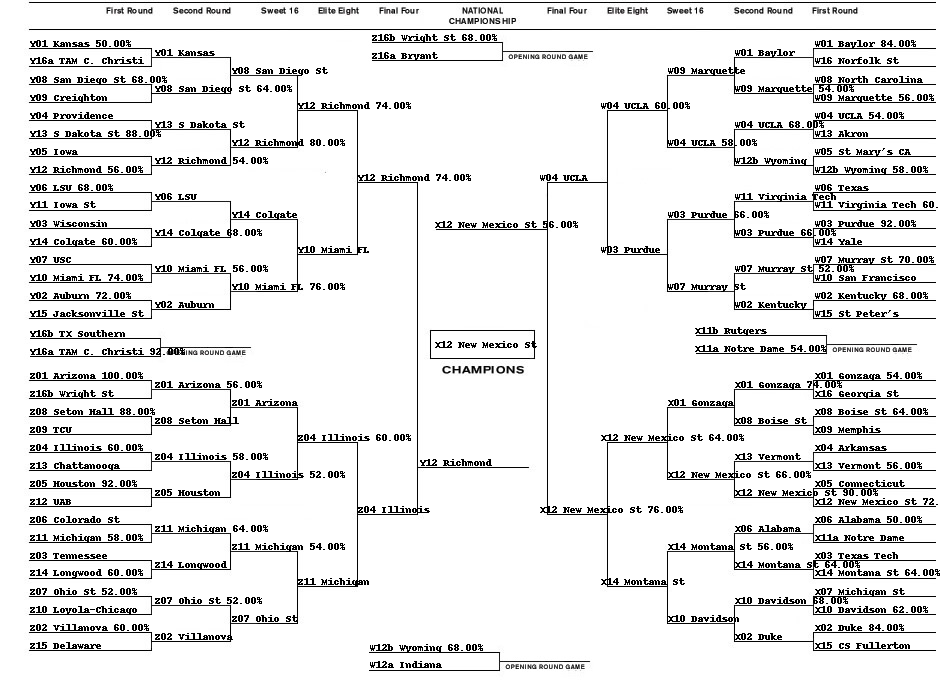

In [ ]:
# !pip install binarytree==6.2.0
# !pip install bracketeer==0.2.0
# !pip install setuptools_scm==6.0.1

from bracketeer import build_bracket
from IPython.display import display, Image

inp = dataPath+ "/"

b = build_bracket(
outputPath='MNCAA2022.png',
teamsPath=inp+'MTeams.csv',
seedsPath=inp+'MNCAATourneySeeds.csv',
submissionPath='submissionMarkovModel.csv',
slotsPath=inp+'MNCAATourneySlots.csv',
year=2022
)

display(Image(filename='./MNCAA2022.png'))